In [1]:
!pip install face_recognition
!pip install tensorflow_addons

     |████████████████████████████████| 100.1 MB 21 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=ef5bbd0512eb06ec2bbf7f4de469c13c1eb71ca6f67955706a31afabe8406897
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
     |████████████████████████████████| 1.1 MB 3.8 MB/s 


In [2]:
import cv2
import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

from face_recognition import face_locations

#tripple_lost_function
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for training model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

#for JS draw
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import base64
import PIL
import io
import html
import time
from PIL import Image
import cv2
from scipy import spatial

#Model built-in

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load dataset**

In [4]:
path_dataset = "/content/drive/MyDrive/face_recognition/FacenetDataset.zip"
!unzip /content/drive/MyDrive/face_recognition/FacenetDataset.zip -d /content/

Archive:  /content/drive/MyDrive/face_recognition/FacenetDataset.zip
   creating: /content/FacenetDataset/
  inflating: /content/__MACOSX/._FacenetDataset  
  inflating: /content/FacenetDataset/.DS_Store  
  inflating: /content/__MACOSX/FacenetDataset/._.DS_Store  
   creating: /content/FacenetDataset/Phong/
  inflating: /content/__MACOSX/FacenetDataset/._Phong  
   creating: /content/FacenetDataset/Hellas/
  inflating: /content/__MACOSX/FacenetDataset/._Hellas  
   creating: /content/FacenetDataset/Nguyen/
  inflating: /content/__MACOSX/FacenetDataset/._Nguyen  
   creating: /content/FacenetDataset/Huy/
  inflating: /content/__MACOSX/FacenetDataset/._Huy  
   creating: /content/FacenetDataset/Phu/
  inflating: /content/__MACOSX/FacenetDataset/._Phu  
  inflating: /content/FacenetDataset/Phong/8.jpg  
  inflating: /content/FacenetDataset/Phong/9.jpg  
  inflating: /content/FacenetDataset/Phong/14.jpg  
  inflating: /content/FacenetDataset/Phong/28.jpg  
  inflating: /content/FacenetDat

In [5]:
!git clone https://github.com/pyannote/pyannote-data

Cloning into 'pyannote-data'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 47 (delta 0), reused 27 (delta 0), pack-reused 19
Unpacking objects: 100% (47/47), done.


**Global Variable**

In [12]:
dataset_path = "/content/FacenetDataset"
model_path = "/content/pyannote-data/openface.nn4.small2.v1.t7"

**Model**

In [13]:
def _load_torch(model_path_fl):
    model = cv2.dnn.readNetFromTorch(model_path_fl)
    return model

encoder = _load_torch(model_path)

def _image_read(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def _extract_bbox(image, single = True):
    bboxs = face_locations(image)
    if len(bboxs)==0:
      return None
    if single:
      bbox = bboxs[0]
      return bbox
    else:
      return bboxs

def _extract_face(image, bbox, face_scale_thres = (20, 20)):
      h, w = image.shape[:2]
      try:
        (startX, startY, endX, endY) = bbox
      except:
        return None
      minX, maxX = min(startX, endX), max(startX, endX)
      minY, maxY = min(startY, endY), max(startY, endY)
      face = image[minY:maxY, minX:maxX].copy()
      # extract the face ROI and grab the ROI dimensions
      (fH, fW) = face.shape[:2]
      print(fH,fW)
      # ensure the face width and height are sufficiently large
      if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
        return None
      else:
        return face

import cv2

def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):
    imageBlob = cv2.dnn.blobFromImage(image, 
                                      scalefactor=scaleFactor,   
                                      size=out_size,  
                                      mean=mean,  
                                      swapRB=False,
                                      crop=False)
    return imageBlob

In [ ]:
def _model_processing(face_scale_thres = (20, 20)):
    image_links = list(paths.list_images(dataset_path))
    # image_links = ["/content/FacenetDataset/Phu/1.jpg"]
    images_file = [] 
    y_labels = []
    faces = []
    total = 0
    for image_link in image_links:
        split_img_links = image_link.split("/")
        if split_img_links[-1] == "script_rename.py":
            continue
        name = split_img_links[-2] 
        print(name)
        image = _image_read(image_link)
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
        FACEnet.setInput(blob)
        detections = FACEnet.forward()
        (h, w) = image.shape[:2]
        # bbox =_extract_bbox(image, single=True)

        for i in range(detections.shape[2]):
            confidence = detections[0,0,i,2]
            if confidence > 0.9:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
              
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
                face = image[startY:endY, startX:endX]
                if face.shape[0] != 0 and face.shape[1] != 0:
                    face = cv2.cvtColor(_blobImage(face), cv2.COLOR_BGR2RGB)
                    # face = cv2.resize(face, (300, 112))
                    faces.append(face)
                    y_labels.append(name)
                    images_file.append(image_links)
                    total += 1
    print("Total bbox face extracted: {}".format(total))
    return faces, y_labels, images_file

1150 795


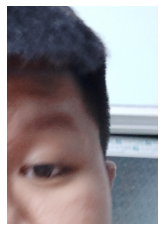

In [ ]:
test_face = "/content/FacenetDataset/Phu/1.jpg"
image = _image_read(test_face)
bbox = _extract_bbox(image)
face = _extract_face(image, bbox)

plt.axis("off")
plt.imshow(face)

In [ ]:
faces, y_labels, images_file = _model_processing()

In [6]:
def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

In [ ]:
path_pickle = "/content/drive/MyDrive/face_recognition/pickle_file"

_save_pickle(faces, path_pickle + "/faces.pkl")
_save_pickle(y_labels, path_pickle + "/y_labels.pkl")
_save_pickle(images_file, path_pickle + "/images_file.pkl")

In [9]:
path_pickle = "/content/drive/MyDrive/face_recognition/pickle_file"

faces = _load_pickle(path_pickle + "/faces.pkl")
y_labels = _load_pickle(path_pickle + "/y_labels.pkl")
image_file = _load_pickle(path_pickle + "/images_file.pkl")

**Embedding_space**

In [14]:
def _embedding_faces(encoder, faces):
    emb_vecs = []
    for face in faces:
      faceBlob = _blobImage(face, out_size = (96, 96), scaleFactor=1/255.0, mean=(0, 0, 0))
      # Embedding face
      encoder.setInput(faceBlob)
      vec = encoder.forward()
      emb_vecs.append(vec)
    return emb_vecs

embed_faces = _embedding_faces(encoder, faces)
_save_pickle(embed_faces, path_pickle + "/embed_blob_faces.pkl")

**Load embedding space**

In [15]:
embed_faces = _load_pickle(path_pickle + "/embed_blob_faces.pkl")
y_labels = _load_pickle(path_pickle + "/y_labels.pkl")

ids = np.arange(len(y_labels))
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(embed_faces), y_labels, ids, test_size = 0.2, stratify = y_labels)
X_train = np.squeeze(X_train, axis = 1)
X_test = np.squeeze(X_test, axis = 1)
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(155, 128) (39, 128)
155 39


In [16]:
_save_pickle(id_train, "./id_train.pkl")
_save_pickle(id_test, "./id_test.pkl")

**Helper Function**

In [17]:
def _most_similarity(embed_vecs, vec, labels):
    sim = cosine_similarity(embed_vecs, vec)
    sim = np.squeeze(sim, axis = 1)
    argmax = np.argsort(sim)[::-1][:1]
    if sim[argmax[0]] < 0:
       return "unknown"
    label = [labels[idx] for idx in argmax][0]
    return label

In [18]:
#test accuracy for pretrain model

y_preds = []
for vec in X_test:
    vec = vec.reshape(1,-1)
    y_preds.append(_most_similarity(X_train,vec,y_train))

print(accuracy_score(y_preds,y_test))

0.9230769230769231


**TripleLost Definition**

In [ ]:
def _base_network():
    model = VGG16(include_top = True, weights = None, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))
    dense = Dense(128)(model.layers[-4].output)
    norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
    model = Model(inputs = [model.input], outputs = [norm2])
    return model

model = _base_network()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [20]:
faces = _load_pickle(path_pickle + "/faces.pkl")

faceResizes = []
for face in faces:
    faceResize = cv2.resize(face,(224,224))
    faceResizes.append(faceResize)

X = np.stack(faceResizes)
X.shape

(194, 224, 224, 3)

In [21]:
id_train = _load_pickle("./id_train.pkl")
id_test = _load_pickle("./id_test.pkl")

X_train, X_test = X[id_train], X[id_test]

print(X_train.shape)
print(X_test.shape)

(155, 224, 224, 3)
(39, 224, 224, 3)


**ModelFacenet**

In [22]:
!git clone https://github.com/gopinath-balu/computer_vision

config_path = "/content/computer_vision/CAFFE_DNN/deploy.prototxt.txt"
weight_path = "/content/computer_vision/CAFFE_DNN/res10_300x300_ssd_iter_140000.caffemodel"

FACEnet = cv2.dnn.readNet(config_path,weight_path)

Cloning into 'computer_vision'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 13 (delta 0), reused 6 (delta 0), pack-reused 7
Unpacking objects: 100% (13/13), done.


**Data augumentation**

In [23]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [24]:
no_batch = 0
X_au = []
y_au = []
for i in np.arange(len(X_train)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_train[i], axis = 0), batch_size = 1):
    X_au.append(x[0])
    y_au.append(y_train[i])
    no_img += 1
    if no_img == 5:
      break

In [25]:
gen_train = tf.data.Dataset.from_tensor_slices((X_au, y_au)).repeat().shuffle(1024).batch(64)
gen_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
45/50 [==========================>...] - ETA: 8s - loss: 0.9192 

In [ ]:
data_tf = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    #horizontal_flip=True
    )

data_tf.fit(X_test)

no_batch = 0
X_test_tf = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in data_tf.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_tf.append(x[0])
    no_img += 1
    if no_img == 1:
      break

X_train_vec = model.predict(np.stack(X_au))
X_test_vec = model.predict(np.stack(X_test_tf))

y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_au)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.17857142857142858


In [ ]:
#facenet: https://colab.research.google.com/drive/1OTSK9mJdtpuzArCTsEKh5eIq5OmOyq2o
def _normalize_image(image, epsilon=0.000001):
    means = np.mean(image.reshape(-1, 3), axis=0)
    stds = np.std(image.reshape(-1, 3), axis=0)
    image_norm = image - means
    image_norm = image_norm/(stds + epsilon)
    return image_norm

**Streaming**

In [ ]:
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
          bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

In [ ]:
start_input()

label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = take_photo(label_html, bbox)
    # js_reply = take_photo(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    image = js_reply_to_image(js_reply)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    w,h = image.shape[:2]
    # print('frame',w,h)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # blob = _blobImage(image)

    # bboxs = _extract_bbox(image, single=False)
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
    FACEnet.setInput(blob)
    detections = FACEnet.forward()
    # FACEnet.setInput(blob)
    # detections = FACEnet.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > 0.5:
          box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
          (startX, startY, endX, endY) = box.astype("int")
        
          (startX, startY) = (max(0, startX), max(0, startY))
          (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        
          face = image[startY:endY, startX:endX]
          face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
          face_rz = cv2.resize(face, (224, 224))
          # Chuẩn hóa ảnh bằng hàm _normalize_image
          face_tf = _normalize_image(face_rz)
          face_tf = np.expand_dims(face_tf, axis = 0)
          # Embedding face
          vec = model.predict(face_tf)
          # Tìm kiếm ảnh gần nhất
          name = _most_similarity(X_train_vec, vec, y_au)
          
          label = name
          if label != "unknown":
            bbox_array = cv2.putText(bbox_array, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,0,225), 2)
            bbox_array = cv2.rectangle(bbox_array, (startX  + 70, startY), (endX + 70, endY), (0,0,255), 2)
          else:
            label = name
            bbox_array = cv2.putText(bbox_array, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,0,0), 2)
            bbox_array = cv2.rectangle(bbox_array, (startX  + 70, startY), (endX + 70, endY), (255,0,0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

<IPython.core.display.Javascript object>